## Introduction

EDA for IASI/METOP C CO data
Original data source: https://iasi.aeris-data.fr/co_iasi_c_arch/

Columns meaning: https://iasi.aeris-data.fr/CO_readme/

Each file contains data for one day of observation. In each file, each line corresponds to one observation.
File names include date of observation. Their structure is:  
iasi_CO_LATMOS_ULB_YYYYMMDD_vXXXXXXXX.txt  
where : YYYY = year, MM = month, DD = day, XXXXXXXX = version number of the retrieval code.  

The data are organized in 60 columns:  

* columns 1 and 2 - latitude and longitude  
* columns 3 and 4 - date (yyyymmdd) and time (hhmmss)  
* column 5 - solar zenith angle  
* column 6 - IASI field of view (0, 1, 2 or 3)  
* column 7 - information flag about Eumetsat IASI L2 temperature profiles retrieval method (see above)  
* columns 8 to 15 - quality flags (see hereafter)  
* column 16 - “super” quality flag (see hereafter)  
* column 17 - Eumetsat cloud coverage in the pixel (in %, between 0 and 25 %)  
* column 18 - Degrees Of Freedom of the Signal (DOFS, ~number of independant information pieces concerning CO vertical distribution in the signal)  
* column 19 - fit residual root mean square (in W/m2/cm-1)  
* column 20 - fit residual bias (in W/m2/cm-1)  
* column 21 - CO total column (in molec.cm-2)  
* column 22 - CO total column relative error (observation_error/observation ratio)  
* columns 23 to 41 - Xa, a priori CO profile in partial columns (in molec.cm-2) and on the same vertical layers as the A matrix, with -999 for missing levels  
* columns 42 to 60 - A, averaging kernel vector for the total column in 19 vertical layers (in partial column), with -999 for missing levels (see hereafter for the description of the layers)  


## Data analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap, HeatMapWithTime


In [2]:
iasi_df = pd.read_csv("../data/iasi-metop/iasi_CO_LATMOS_ULB_metopc_20200101_v20191122.txt", sep=" ", header=None)

In [3]:
iasi_df.shape

(507640, 60)

Filter atmospheric lat/lon/date/hour/CO: 1, 2, 3, 4, 21

In [4]:
iasi_df = iasi_df.iloc[:, [0,1,2,3,20]]
iasi_df.columns = ['lat', 'long', 'date', 'time', 'CO_total']

In [5]:
iasi_df.head()

,lat,long,date,time,CO_total
0,-36.27407,-35.25643,20200101,302,1.998196e+18
1,-36.12484,-33.67857,20200101,303,1.889820e+18
2,-35.77280,-32.08382,20200101,303,1.915132e+18
3,-35.61330,-31.37519,20200101,303,1.811938e+18
4,-35.45435,-31.42245,20200101,303,1.760810e+18


In [6]:
iasi_df.describe()

,lat,long,date,time,CO_total
count,507640.000000,507640.000000,5.076400e+05,507640.000000,5.076400e+05
mean,1.089730,9.532823,2.020010e+07,116975.828002,1.710632e+18
std,46.271385,103.617254,3.755564e-02,70433.452634,8.525458e+17
min,-89.714710,-179.999710,2.020010e+07,0.000000,4.289303e+17
25%,-30.957368,-79.355895,2.020010e+07,54114.000000,1.334052e+18
50%,3.682630,17.354755,2.020010e+07,115330.000000,1.668976e+18
75%,34.426347,98.595883,2.020010e+07,180253.000000,1.937708e+18
max,89.633390,179.999700,2.020010e+07,235960.000000,1.999356e+19


In [7]:
print(iasi_df.nunique())

lat         499236
long        503339
date             2
time         54708
CO_total    443360
dtype: int64


In [8]:
tmp = iasi_df.groupby(['lat', 'long', 'date']).count()
print(tmp.max(), tmp.min(), tmp.shape)

time        1
CO_total    1
dtype: int64 time        1
CO_total    1
dtype: int64 (507640, 2)


In [9]:
min_long = -9
max_long = 50
min_lat = 35
max_lat = 70

eu_iasi_df = iasi_df.loc[(iasi_df.lat > 35) & (iasi_df.lat < 70) & (iasi_df.long > -25) & (iasi_df.long < 70)]
eu_iasi_df.shape

(21574, 5)

In [10]:
eu_iasi_df.describe()

,lat,long,date,time,CO_total
count,21574.000000,21574.000000,21574.0,21574.000000,2.157400e+04
mean,49.220054,23.586828,20200101.0,139020.559841,1.880594e+18
std,10.123049,24.816438,0.0,53952.606464,2.712281e+17
min,35.000060,-24.991000,20200101.0,54801.000000,1.002177e+18
25%,40.746113,5.205827,20200101.0,91615.000000,1.697375e+18
50%,46.914350,20.171385,20200101.0,154221.000000,1.879444e+18
75%,56.060460,43.119925,20200101.0,190234.000000,2.047285e+18
max,69.999060,69.993170,20200101.0,222930.000000,4.859780e+18


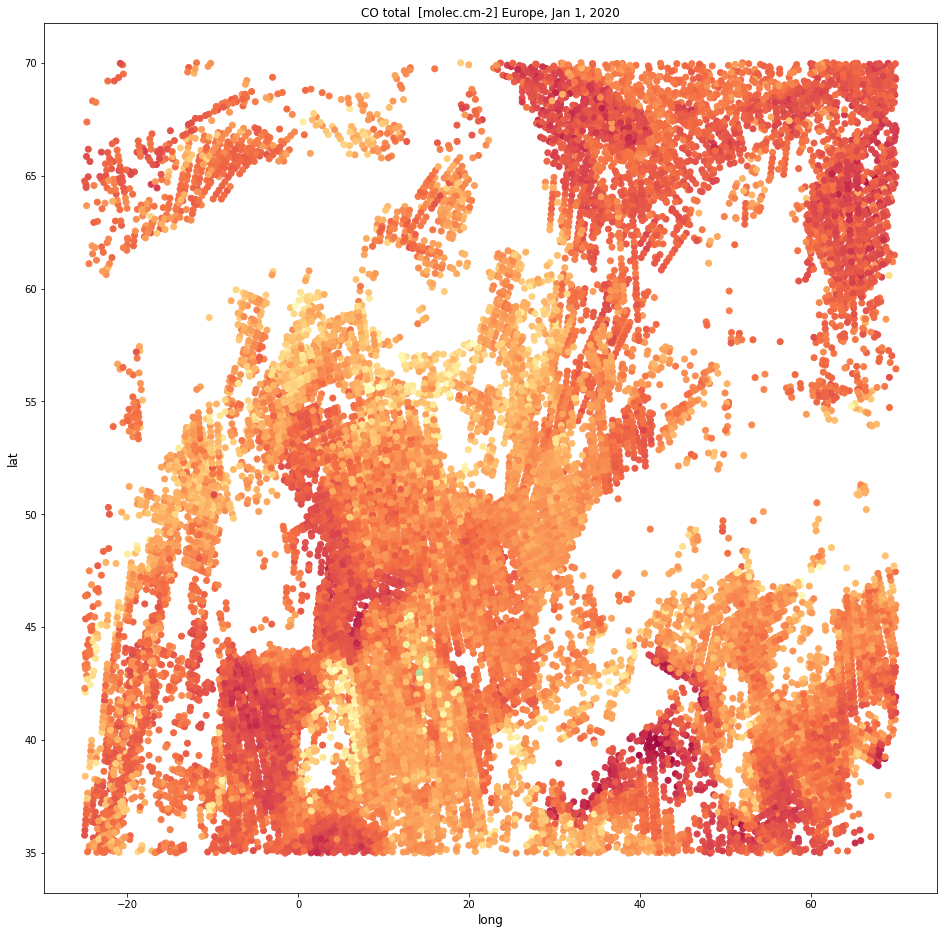

In [11]:
plt.figure(figsize=(16,16))
plt.scatter(x=eu_iasi_df['long'],y=eu_iasi_df['lat'], c=eu_iasi_df['CO_total'], cmap='Spectral')
plt.xlabel('long', fontsize=12); plt.ylabel('lat', fontsize=12)
plt.title("CO total  [molec.cm-2] Europe, Jan 1, 2020")
plt.show();

In [12]:
m = folium.Map(location=[54,15], zoom_start=4)
max_val = max(eu_iasi_df['CO_total'])
HeatMap(data=eu_iasi_df[['lat', 'long', 'CO_total']],\
        radius=9, max_zoom=8).add_to(m)
m

### Save filtered CO total data for Europe

In [13]:
eu_iasi_df.to_csv("../data/iasi-metop/eu_iasi_CO_LATMOS_ULB_metopc_20200101_v20191122.csv", index=False)